In [ ]:
import numpy as np
import pandas as pd
#import yfinance as yf
from copy import deepcopy as dc

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('AMZN.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date','Close']]
df

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


<ipython-input-25-67d0a9b3f059>:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


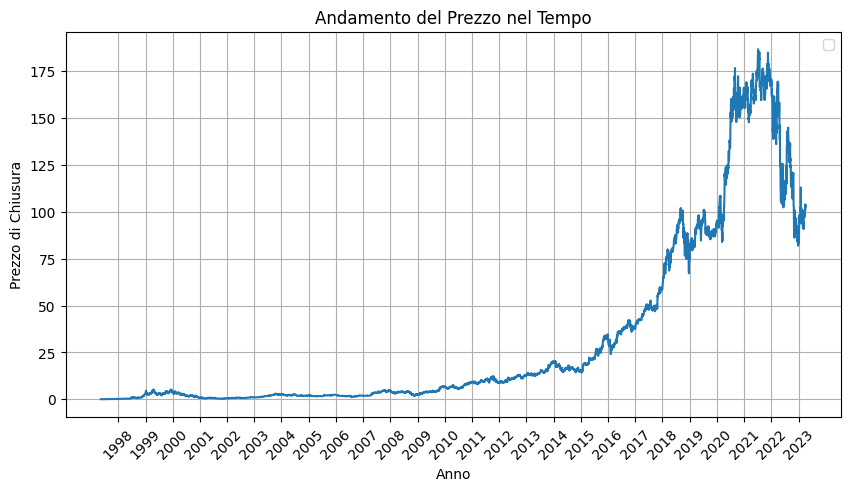

In [ ]:
# Fai una copia del DataFrame per evitare di modificare quello originale
df_copy = df.copy()

# Estrai l'anno nella copia
df_copy['Year'] = df_copy['Date'].dt.year

# Filtra il primo dato per ogni anno sulla copia
df_first_of_year = df_copy.drop_duplicates(subset='Year', keep='first')

# Escludi l'anno 1997 dalla copia
df_first_of_year = df_first_of_year[df_first_of_year['Year'] != 1997]

# Crea il grafico
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'])

# Imposta i tick dell'asse X solo sui primi dati di ogni anno, escluso il 1997
plt.gca().set_xticks(df_first_of_year['Date'])
plt.gca().set_xticklabels(df_first_of_year['Year'], rotation=45)  # Mostra solo l'anno

plt.xlabel('Anno')
plt.ylabel('Prezzo di Chiusura')
plt.title('Andamento del Prezzo nel Tempo')
plt.legend()
plt.grid()

plt.show()

In [ ]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
27/05/1997,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
28/05/1997,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
29/05/1997,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
30/05/1997,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
02/06/1997,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
30/03/2023,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
31/03/2023,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
03/04/2023,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [ ]:
# Prepara lo scaler e scala i dati
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(shifted_df)
scaled_data

array([[4.46864078e-05, 2.23432039e-05, 0.00000000e+00, ...,
        8.37798446e-05, 8.93615930e-05, 1.50803720e-04],
       [3.07239161e-05, 4.46864078e-05, 2.79248276e-05, ...,
        6.42303205e-05, 8.37798446e-05, 8.93615930e-05],
       [2.37373083e-05, 3.07239161e-05, 5.02679068e-05, ...,
        8.37530351e-06, 6.42303205e-05, 8.37798446e-05],
       ...,
       [5.48736493e-01, 5.53454984e-01, 5.46540607e-01, ...,
        5.25307449e-01, 5.25789999e-01, 5.28899918e-01],
       [5.56993843e-01, 5.48736493e-01, 5.53457476e-01, ...,
        5.21017905e-01, 5.25307449e-01, 5.25789999e-01],
       [5.41712319e-01, 5.56993843e-01, 5.48739012e-01, ...,
        5.37157265e-01, 5.21017905e-01, 5.25307449e-01]])

# 1. Creazione dati base

In [ ]:
# Prepara X e y
X = scaled_data[:, 1:]  # Tutte le colonne tranne la prima (che è Close attuale)
y = scaled_data[:, 0]   # Prima colonna (Close attuale)

# Split train/test (80% train)
train_size = int(len(X) * 0.8)
X_train_base = X[:train_size]
X_test = X[train_size:]
y_train_base = y[:train_size]
y_test = y[train_size:]

print("Forma X_train:", X_train_base.shape)
print("Forma X_test:", X_test.shape)
print("Forma y_train:", y_train_base.shape)
print("Forma y_test:", y_test.shape)

Forma X_train: (5207, 7)
Forma X_test: (1302, 7)
Forma y_train: (5207,)
Forma y_test: (1302,)


# 2. Creazione dati con jittering

In [ ]:
# Jittering dei dati
def apply_jittering(X, std=0.01, n_samples=1):
    jittered_data = []
    for _ in range(n_samples):
        noise = np.random.normal(0, std, X.shape)
        jittered_data.append(X + noise)
    return np.vstack([X] + jittered_data)

# Applica jittering
X_train_jitter = apply_jittering(X_train_base, std=0.01, n_samples=2)
y_train_jitter = np.tile(y_train_base, 3)

In [ ]:
X_train_jitter.shape

(15621, 7)

# 3. Creazione dati con GAN

In [ ]:
# Generatore
def build_generator(latent_dim, n_features):
    model = tf.keras.Sequential([
        Dense(128, input_shape=(latent_dim,)),
        Dense(64, activation='relu'),
        Dense(n_features, activation='tanh')
    ])
    return model

# Discriminatore
def build_discriminator(n_features):
    model = tf.keras.Sequential([
        Dense(64, input_shape=(n_features,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Training GAN
latent_dim = 50
generator = build_generator(latent_dim, 7)  # 7 features (7 periodi precedenti)
discriminator = build_discriminator(7)

discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

gan = tf.keras.Sequential([generator, discriminator])
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training loop semplificato
batch_size = 32
n_epochs = 100
for epoch in range(n_epochs):
    # Training discriminator
    idx = np.random.randint(0, X_train_base.shape[0], batch_size)
    real_data = X_train_base[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Training generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

# Genera dati sintetici
n_synthetic = X_train_base.shape[0]
noise = np.random.normal(0, 1, (n_synthetic, latent_dim))
X_train_gan = np.vstack([X_train_base, generator.predict(noise)])
y_train_gan = np.tile(y_train_base, 2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [ ]:
X_train_gan.shape

(10414, 7)

# 4. Creazione e training dei modelli

In [ ]:
def create_model(n_features):
    inputs = Input(shape=(n_features,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Crea e addestra i tre modelli
model_base = create_model(7)
model_jitter = create_model(7)
model_gan = create_model(7)

# Training
history_base = model_base.fit(X_train_base, y_train_base,
                            epochs=50, batch_size=32, validation_split=0.1, verbose=1)

history_jitter = model_jitter.fit(X_train_jitter, y_train_jitter,
                                epochs=50, batch_size=32, validation_split=0.1, verbose=1)

history_gan = model_gan.fit(X_train_gan, y_train_gan,
                          epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.7536e-04 - val_loss: 1.1217e-04
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4844e-06 - val_loss: 1.5703e-04
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5024e-06 - val_loss: 1.2882e-04
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1260e-06 - val_loss: 8.3259e-05
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0670e-06 - val_loss: 9.4450e-05
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8318e-06 - val_loss: 1.7491e-04
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4059e-06 - val_loss: 1.2316e-04
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3178e-06 - val_loss: 7.8932e-05
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3988e-06 - val_loss: 1.1210e-04
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1694e-06 - val_loss: 1.3267e-04
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

# 5. Valutazione e confronto

In [ ]:
# Predizioni
y_pred_base = model_base.predict(X_test)
y_pred_jitter = model_jitter.predict(X_test)
y_pred_gan = model_gan.predict(X_test)

# Inverse transform per le predizioni
# Creiamo array temporanei con la stessa struttura dei dati originali
temp = np.zeros((len(y_test), scaled_data.shape[1]))
temp[:, 0] = y_test
y_test_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_base.flatten()
y_pred_base_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_jitter.flatten()
y_pred_jitter_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_gan.flatten()
y_pred_gan_real = scaler.inverse_transform(temp)[:, 0]

# Calcolo metriche
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

metrics_base = calculate_metrics(y_test_real, y_pred_base_real)
metrics_jitter = calculate_metrics(y_test_real, y_pred_jitter_real)
metrics_gan = calculate_metrics(y_test_real, y_pred_gan_real)

# DataFrame con le metriche
metrics_df = pd.DataFrame({
    'Base Model': metrics_base,
    'Jittering Model': metrics_jitter,
    'GAN Model': metrics_gan
}, index=['RMSE', 'MAE', 'MAPE (%)'])

print("\nConfronto delle metriche:")
print(metrics_df)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Confronto delle metriche:
          Base Model  Jittering Model  GAN Model
RMSE       13.636039         7.261953   4.308714
MAE        11.932870         5.528839   3.194138
MAPE (%)    9.451550         4.247879   2.646465


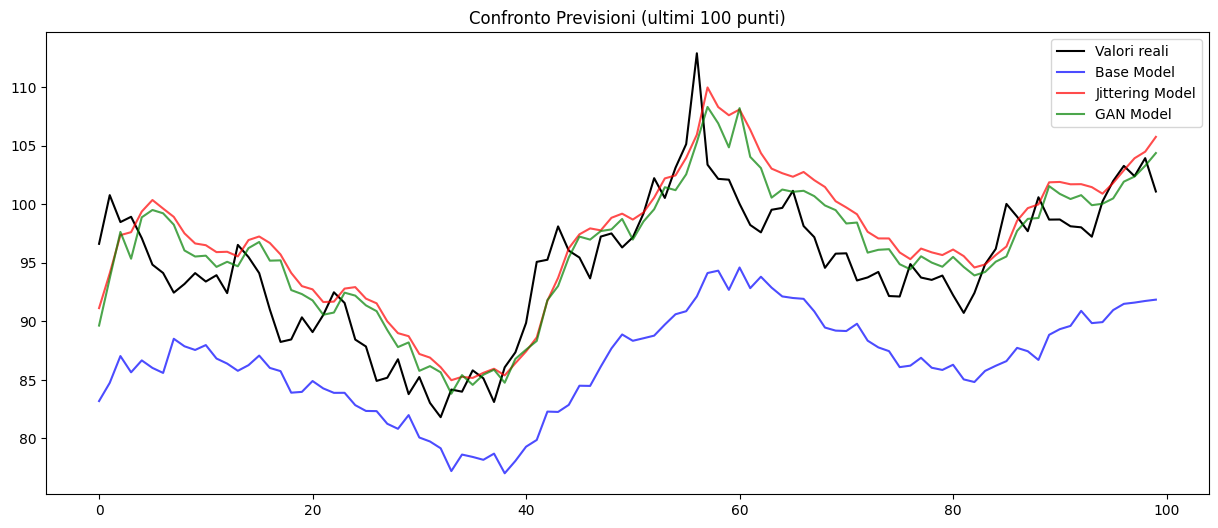

In [ ]:
# Visualizzazione risultati
plt.figure(figsize=(15, 6))
plt.plot(y_test_real[-100:], label='Valori reali', color='black')
plt.plot(y_pred_base_real[-100:], label='Base Model', color='blue', alpha=0.7)
plt.plot(y_pred_jitter_real[-100:], label='Jittering Model', color='red', alpha=0.7)
plt.plot(y_pred_gan_real[-100:], label='GAN Model', color='green', alpha=0.7)
plt.title('Confronto Previsioni (ultimi 100 punti)')
plt.legend()
plt.show()

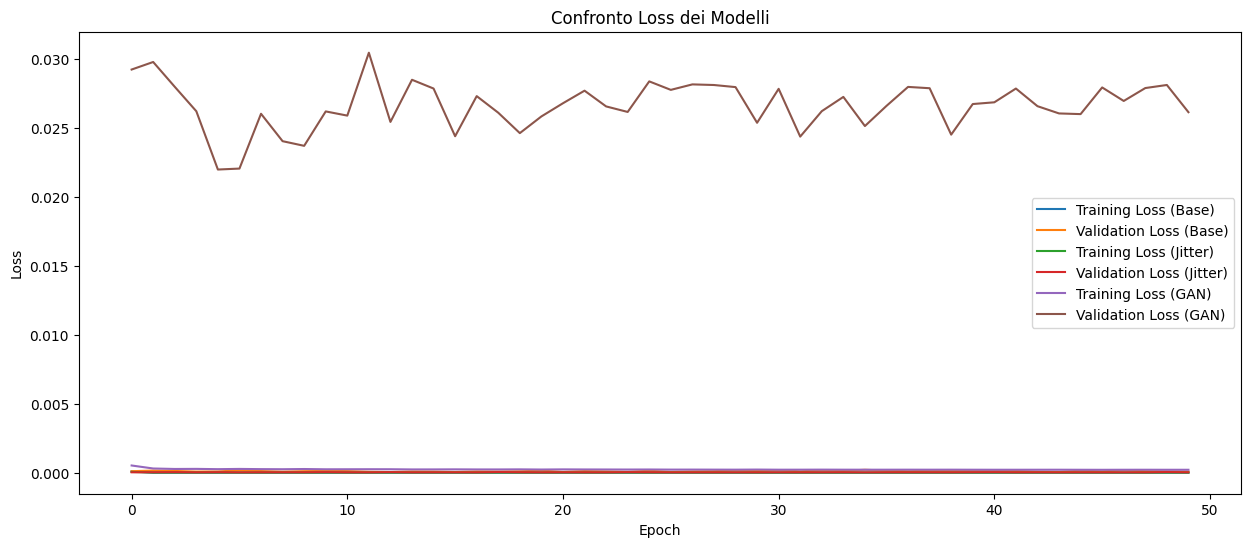

In [ ]:
# Confronto delle loss
plt.figure(figsize=(15, 6))
plt.plot(history_base.history['loss'], label='Training Loss (Base)')
plt.plot(history_base.history['val_loss'], label='Validation Loss (Base)')
plt.plot(history_jitter.history['loss'], label='Training Loss (Jitter)')
plt.plot(history_jitter.history['val_loss'], label='Validation Loss (Jitter)')
plt.plot(history_gan.history['loss'], label='Training Loss (GAN)')
plt.plot(history_gan.history['val_loss'], label='Validation Loss (GAN)')
plt.title('Confronto Loss dei Modelli')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Miglioramento GAN

In [ ]:
# Architettura GAN migliorata
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        Dense(256, input_shape=(latent_dim,)),
        tf.keras.layers.LeakyReLU(0.2),
        Dense(128),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.BatchNormalization(),
        Dense(64),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.BatchNormalization(),
        Dense(7, activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        Dense(128, input_shape=(7,)),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.3),
        Dense(64),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.3),
        Dense(32),
        tf.keras.layers.LeakyReLU(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

# Configurazione del training
latent_dim = 100  # Aumentato
generator = build_generator(latent_dim)
discriminator = build_discriminator()

# Compile separatamente
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

# Crea il GAN completo
discriminator.trainable = False
gan = tf.keras.Sequential([generator, discriminator])
gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

# Training loop migliorato
batch_size = 64  # Aumentato
n_epochs = 200   # Aumentato
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    # Training del discriminatore
    for _ in range(2):  # Train discriminator more
        # Real data
        idx = np.random.randint(0, X_train_base.shape[0], batch_size)
        real_sequences = X_train_base[idx].reshape(batch_size, 7)

        # Fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_sequences = generator.predict(noise)

        # Label smoothing
        real_labels = np.random.uniform(0.9, 1.0, (batch_size, 1))
        fake_labels = np.random.uniform(0.0, 0.1, (batch_size, 1))

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_sequences, fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

    # Training del generator
    noise = np.random.normal(0, 1, (batch_size * 2, latent_dim))
    valid_labels = np.ones((batch_size * 2, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Salva le loss
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Genera dati sintetici con più varietà
noise_scale = np.linspace(0.5, 1.5, X_train_base.shape[0])
noise = np.random.normal(0, noise_scale[:, np.newaxis], (X_train_base.shape[0], latent_dim))
synthetic_sequences = generator.predict(noise)

# Filtra le sequenze generate
# Calcola la media e std dev dei dati reali
real_mean = np.mean(X_train_base)
real_std = np.std(X_train_base)

# Filtra le sequenze che sono troppo diverse dai dati reali
valid_sequences = []
for seq in synthetic_sequences:
    if (np.mean(seq) > real_mean - 2*real_std and
        np.mean(seq) < real_mean + 2*real_std):
        valid_sequences.append(seq)

synthetic_sequences = np.array(valid_sequences)

# Reshape X_train_base to have 3 dimensions before stacking
X_train_base_reshaped = X_train_base.reshape(X_train_base.shape[0], X_train_base.shape[1], 1)

# Now stack the reshaped arrays
X_train_gan = np.vstack([X_train_base, synthetic_sequences]) # Stack with original shape

# The rest of the code remains the same
y_train_gan = np.tile(y_train_base, 2) # Adjust tiling to 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 0, D Loss: 0.6887, G Loss: 0.6725
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 10, D Loss: 0.6916, G Loss: 0.6720
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━

In [ ]:
model_gan_1 = create_model(7)

# Training the GAN model
history_gan_1 = model_gan_1.fit(X_train_gan, y_train_gan, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0029 - val_loss: 4.9143e-04
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1837e-04 - val_loss: 3.3281e-04
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3267e-05 - val_loss: 3.0450e-04
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7567e-05 - val_loss: 3.1094e-04
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6267e-05 - val_loss: 2.3359e-04
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.5797e-05 - val_loss: 1.8186e-04
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1480e-05 - val_loss: 2.8246e-04
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7114e-05 - val_loss: 1.9737e-04
Epoch 9/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7068e-05 - val_loss: 4.2105e-04
Epoch 10/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9306e-05 - val_loss: 1.6189e-04
Epoch 11/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.

## Valutazione e confronto

In [ ]:
# Predizioni
y_pred_base = model_base.predict(X_test)
y_pred_jitter = model_jitter.predict(X_test)
y_pred_gan_1 = model_gan_1.predict(X_test) # Changed to model_gan_1

# Inverse transform per le predizioni
# Creiamo array temporanei con la stessa struttura dei dati originali
temp = np.zeros((len(y_test), scaled_data.shape[1]))
temp[:, 0] = y_test
y_test_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_base.flatten()
y_pred_base_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_jitter.flatten()
y_pred_jitter_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_gan_1.flatten() # Changed to y_pred_gan_1
y_pred_gan_1_real = scaler.inverse_transform(temp)[:, 0] # Changed to y_pred_gan_1_real


# Calcolo metriche
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

metrics_base = calculate_metrics(y_test_real, y_pred_base_real)
metrics_jitter = calculate_metrics(y_test_real, y_pred_jitter_real)
metrics_gan_1 = calculate_metrics(y_test_real, y_pred_gan_1_real) # Changed to metrics_gan_1


# DataFrame con le metriche
metrics_df = pd.DataFrame({
    'Base Model': metrics_base,
    'Jittering Model': metrics_jitter,
    'GAN Model': metrics_gan_1  # Changed to metrics_gan_1
}, index=['RMSE', 'MAE', 'MAPE (%)'])

print("\nConfronto delle metriche:")
print(metrics_df)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Confronto delle metriche:
          Base Model  Jittering Model  GAN Model
RMSE       13.636039         7.261953  10.507752
MAE        11.932870         5.528839   7.836309
MAPE (%)    9.451550         4.247879   5.607186


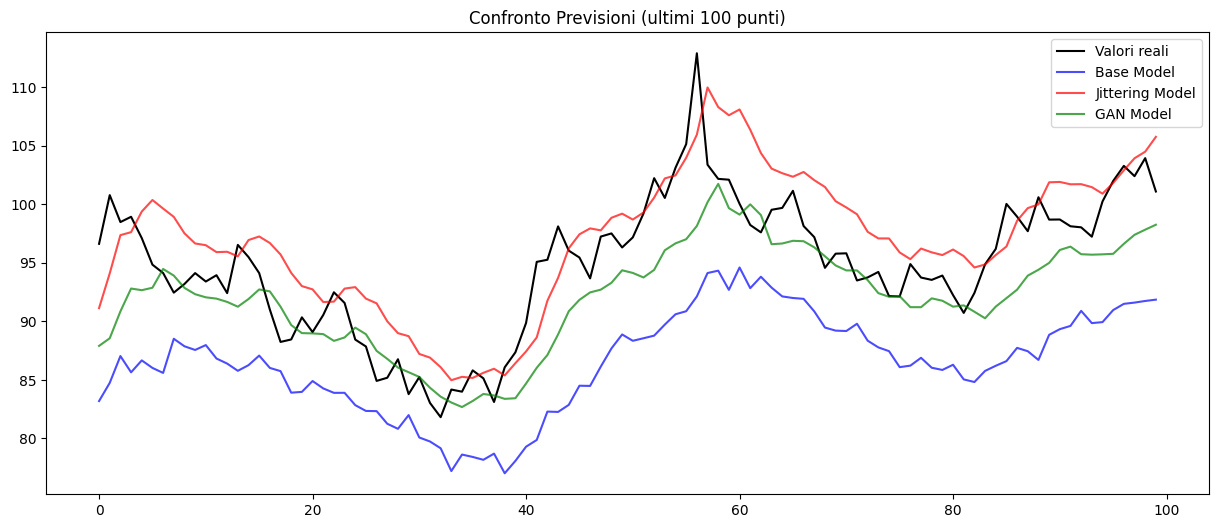

In [ ]:
# Visualizzazione risultati
plt.figure(figsize=(15, 6))
plt.plot(y_test_real[-100:], label='Valori reali', color='black')
plt.plot(y_pred_base_real[-100:], label='Base Model', color='blue', alpha=0.7)
plt.plot(y_pred_jitter_real[-100:], label='Jittering Model', color='red', alpha=0.7)
plt.plot(y_pred_gan_1_real[-100:], label='GAN Model', color='green', alpha=0.7) # Changed to y_pred_gan_1_real
plt.title('Confronto Previsioni (ultimi 100 punti)')
plt.legend()
plt.show()


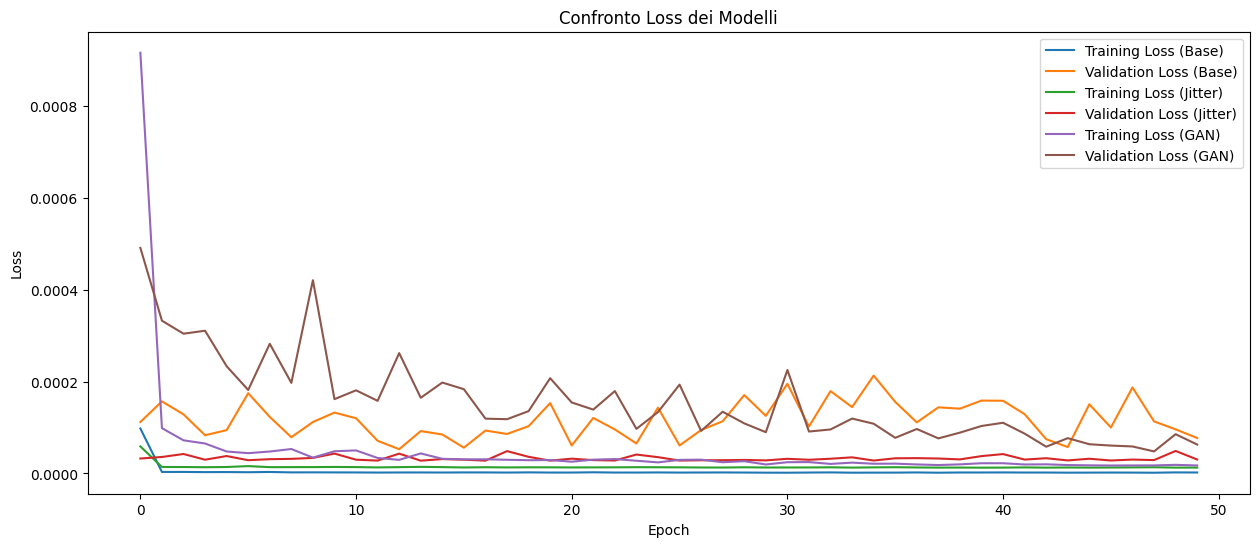

In [ ]:
# Confronto delle loss
plt.figure(figsize=(15, 6))
plt.plot(history_base.history['loss'], label='Training Loss (Base)')
plt.plot(history_base.history['val_loss'], label='Validation Loss (Base)')
plt.plot(history_jitter.history['loss'], label='Training Loss (Jitter)')
plt.plot(history_jitter.history['val_loss'], label='Validation Loss (Jitter)')
plt.plot(history_gan_1.history['loss'], label='Training Loss (GAN)')
plt.plot(history_gan_1.history['val_loss'], label='Validation Loss (GAN)')
plt.title('Confronto Loss dei Modelli')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()